In [28]:
import numpy as np


r2 = np.load('r2_convlstm_1layer.npy')
r2_wandb = np.load('r2_convlstm_1layer_wandb.npy')
r2_3 = np.load('r2_convlstm_wandb.npy')
r2_4 = np.load('r2_unet_wandb.npy')
mask = np.load('mask.npy')

"\na = np.multiply(r2_4-r2_wandb,mask[:112,:112])\na[a==0] = np.nan\nplt.imshow(a, vmin=0, vmax=1, cmap='jet')\nplt.colorbar()\n"

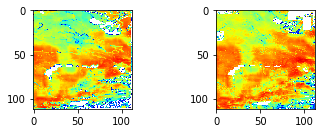

In [33]:
import matplotlib.pyplot as plt

r2[r2==0] = np.nan
r2_4[r2_4==0] = np.nan

plt.subplot(2,2,1)
plt.imshow(r2, vmin=0, vmax=1, cmap='jet')
plt.subplot(2,2,2)
plt.imshow(r2_4, vmin=0, vmax=1, cmap='jet')

"""
a = np.multiply(r2_4-r2_wandb,mask[:112,:112])
a[a==0] = np.nan
plt.imshow(a, vmin=0, vmax=1, cmap='jet')
plt.colorbar()
"""